In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetV2B2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam


In [2]:
# Set dataset path
base_dir = "../dataset"

# List categories (folders in dataset)
categories = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

# Image size to resize to
img_size = 224

# Batch size for training
batch_size = 32


In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,         # 80% train, 20% val
    rotation_range=30,            # rotate image randomly
    width_shift_range=0.2,        # shift image width
    height_shift_range=0.2,       # shift image height
    shear_range=0.2,              # shear transformation
    zoom_range=0.2,               # zoom
    horizontal_flip=True,         # flip image horizontally
    fill_mode='nearest'           # fill strategy for augmented pixels
)


In [4]:



# Load training images
train_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

# Load validation images
val_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)


Found 479 images belonging to 6 classes.
Found 118 images belonging to 6 classes.


In [5]:
from tensorflow.keras.applications import EfficientNetV2B2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

# Create the base model from the pre-trained EfficientNetV2B2
base_model = EfficientNetV2B2(include_top=False, input_shape=(img_size, img_size, 3), weights='imagenet')

# Freeze the base model
#base_model.trainable = False
base_model.trainable = True
for layer in base_model.layers[:-20]:
    layer.trainable = False


# Build the model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(6, activation='softmax')  # 6 classes: cardboard, glass, metal, paper, plastic, trash
])

# Compile the model
model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetv2-b2 (Functional)  │ (None, 7, 7, 1408)     │     8,769,374 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1408)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1408)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       180,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,950,500 (34.14 MB)

 Trainable params: 1,143,706 (4.36 MB)

 Non-trainable params: 7,806,794 (29.78 MB)

In [6]:
from tensorflow.keras.applications import EfficientNetV2B2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout

# Load EfficientNetV2B2 base model (without top layer)
base_model = EfficientNetV2B2(
    include_top=False,
    weights='imagenet',
    input_shape=(img_size, img_size, 3)
)

# Freeze all layers in the base model
#base_model.trainable = False
base_model.trainable = True
for layer in base_model.layers[:-20]:
    layer.trainable = False



# Add custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
predictions = Dense(6, activation='softmax')(x)  # 6 output classes

# Final model
model = Model(inputs=base_model.input, outputs=predictions)


In [7]:
from tensorflow.keras.optimizers import Adam

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Display model architecture
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ input_layer_2[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_1     │ (None, 224, 224,  │          0 │ rescaling_1[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ normalization_1[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │      4,608 │ stem_activation[… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 112, 112,  │         64 │ block1a_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, 112, 112,  │          0 │ block1a_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_co… │ (None, 112, 112,  │      2,304 │ block1a_project_… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_bn  │ (None, 112, 112,  │         64 │ block1b_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_ac… │ (None, 112, 112,  │          0 │ block1b_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_drop        │ (None, 112, 112,  │          0 │ block1b_project_… │
│ (Dropout)           │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_add (Add)   │ (None, 112, 112,  │          0 │ block1b_drop[0][… │
│                     │ 16)               │            │ block1a_project_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, 56, 56,    │      9,216 │ block1b_add[0][0] │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, 56, 56,    │        256 │ block2a_expand_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, 56, 56,    │          0 │ block2a_expand_b

 Total params: 8,777,828 (33.48 MB)

 Trainable params: 971,034 (3.70 MB)

 Non-trainable params: 7,806,794 (29.78 MB)

In [8]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Get the class indices from the generator
class_indices = train_generator.class_indices
labels = list(class_indices.keys())

# Count samples per class
class_counts = {label: 0 for label in labels}
for _, y_batch in train_generator:
    for i in np.argmax(y_batch, axis=1):
        class_counts[labels[i]] += 1
    # Stop after one full epoch worth of data
    if sum(class_counts.values()) >= train_generator.samples:
        break

# Compute class weights
class_weight_values = compute_class_weight(
    class_weight='balanced',
    classes=np.arange(len(labels)),
    y=[label_idx for label, count in class_counts.items() for label_idx in [labels.index(label)] * count]
)

# Create dictionary
class_weight_dict = {i: class_weight_values[i] for i in range(len(labels))}

print("Computed class weights:", class_weight_dict)


Computed class weights: {0: np.float64(0.9979166666666667), 1: np.float64(0.9979166666666667), 2: np.float64(0.9979166666666667), 3: np.float64(0.9979166666666667), 4: np.float64(1.010548523206751), 5: np.float64(0.9979166666666667)}


In [9]:
# Train the model
history = model.fit(
    train_generator,
    epochs=80,  # You can increase for better accuracy
    validation_data=val_generator,
    class_weight=class_weight_dict

)


/Users/devidesai28/Documents/garbage-project/venv/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/80
15/15 ━━━━━━━━━━━━━━━━━━━━ 18s 820ms/step - accuracy: 0.1470 - loss: 1.8150 - val_accuracy: 0.1610 - val_loss: 1.7922
Epoch 2/80
15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 750ms/step - accuracy: 0.1641 - loss: 1.8085 - val_accuracy: 0.1695 - val_loss: 1.7941
Epoch 3/80
15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 746ms/step - accuracy: 0.1684 - loss: 1.8095 - val_accuracy: 0.1695 - val_loss: 1.7917
Epoch 4/80
15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 726ms/step - accuracy: 0.1522 - loss: 1.8085 - val_accuracy: 0.1695 - val_loss: 1.7933
Epoch 5/80
15/15 ━━━━━━━━━━━━━━━━━━━━ 12s 798ms/step - accuracy: 0.1427 - loss: 1.8097 - val_accuracy: 0.1610 - val_loss: 1.7932
Epoch 6/80
15/15 ━━━━━━━━━━━━━━━━━━━━ 12s 805ms/step - accuracy: 0.1756 - loss: 1.7996 - val_accuracy: 0.1610 - val_loss: 1.7896
Epoch 7/80
15/15 ━━━━━━━━━━━━━━━━━━━━ 12s 802ms/step - accuracy: 0.1811 - loss: 1.7918 - val_accuracy: 0.2203 - val_loss: 1.7907
Epoch 8/80
15/15 ━━━━━━━━━━━━━━━━━━━━ 12s 794ms/step - accuracy: 0.1313 - loss: 1.7992 - val_accu

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 581ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 640ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 725ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 524ms/step


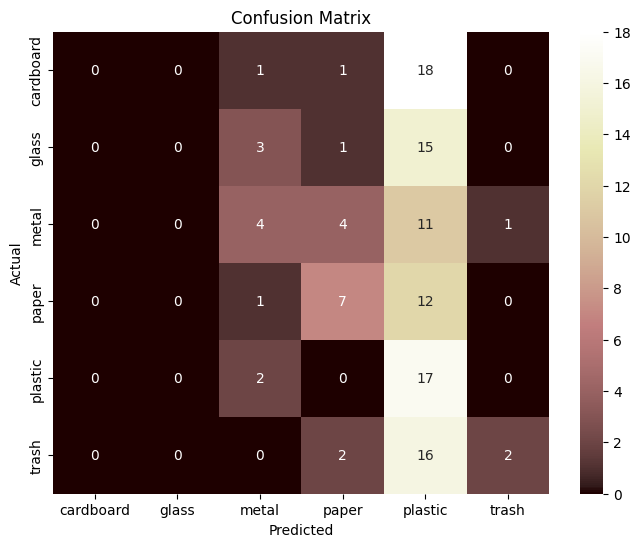


Classification Report:

              precision    recall  f1-score   support

   cardboard       0.00      0.00      0.00        20
       glass       0.00      0.00      0.00        19
       metal       0.36      0.20      0.26        20
       paper       0.47      0.35      0.40        20
     plastic       0.19      0.89      0.31        19
       trash       0.67      0.10      0.17        20

    accuracy                           0.25       118
   macro avg       0.28      0.26      0.19       118
weighted avg       0.28      0.25      0.19       118



/Users/devidesai28/Documents/garbage-project/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/devidesai28/Documents/garbage-project/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/devidesai28/Documents/garbage-project/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavio

In [11]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np

# Get true labels and predictions
Y_true = []
Y_pred = []

for i in range(len(val_generator)):
    x_val, y_val = val_generator[i]
    y_pred = model.predict(x_val)
    Y_true.extend(np.argmax(y_val, axis=1))
    Y_pred.extend(np.argmax(y_pred, axis=1))

# Confusion matrix
cm = confusion_matrix(Y_true, Y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="pink", xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title("Confusion Matrix")
plt.show()

# Classification report
print("\nClassification Report:\n")
print(classification_report(Y_true, Y_pred, target_names=categories))


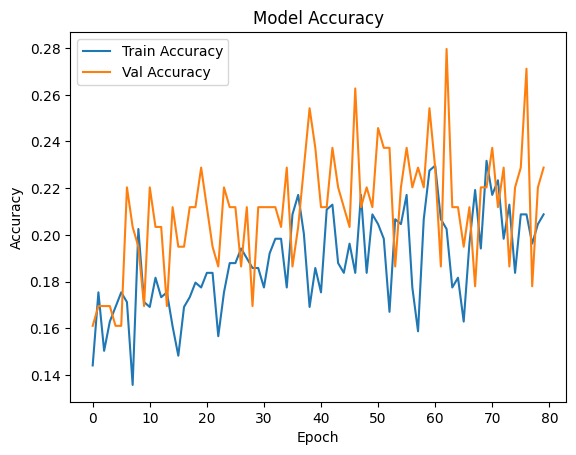

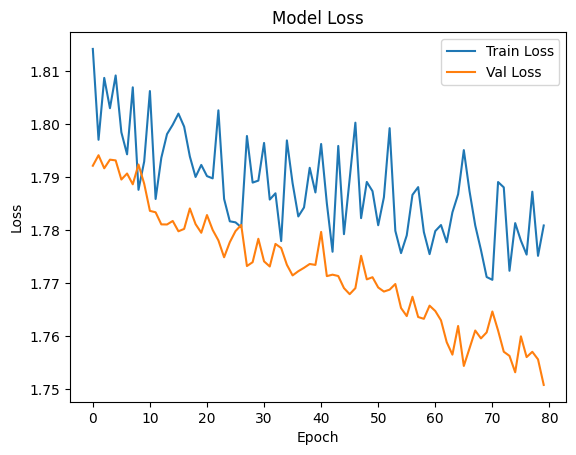

In [12]:
import matplotlib.pyplot as plt

# Accuracy Plot
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss Plot
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
Raw Prediction Vector: [[0.1709675  0.17569184 0.15816644 0.14127877 0.18032749 0.17356798]]
Predicted Index: 4
Predicted Class: plastic
Confidence: 18.03%


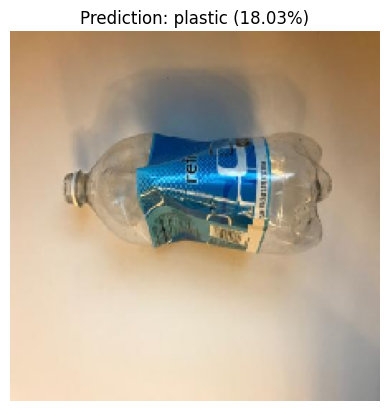

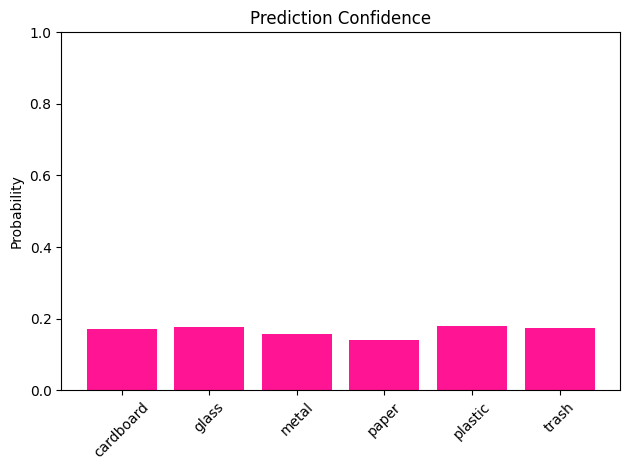

In [18]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Define categories
categories = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

# Load and preprocess the image
img_path = '/Users/devidesai28/Documents/garbage-project/test_images/plastic_147.jpg'  # change to your image
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

# Predict
prediction = model.predict(img_array)
predicted_index = np.argmax(prediction)
predicted_class = categories[predicted_index]
confidence = np.max(prediction) * 100

# Show results
print("Raw Prediction Vector:", prediction)
print("Predicted Index:", predicted_index)
print("Predicted Class:", predicted_class)
print("Confidence: {:.2f}%".format(confidence))

# Display image and prediction
plt.imshow(img)
plt.title(f"Prediction: {predicted_class} ({confidence:.2f}%)")
plt.axis('off')
plt.show()

# Plot confidence chart
fig, ax = plt.subplots()
ax.bar(categories, prediction[0], color='deeppink')
ax.set_ylabel('Probability')
ax.set_title('Prediction Confidence')
ax.set_ylim([0, 1])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [20]:
model.save("garbage_classifier_model.keras")


In [21]:
print(train_generator.class_indices)


{'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}


In [22]:
import os
from collections import Counter

train_dir = '/Users/devidesai28/Documents/garbage-project/dataset'
class_counts = {}

for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path):
        class_counts[class_name] = len(os.listdir(class_path))

print("Class counts:", class_counts)


Class counts: {'paper': 100, 'metal': 100, 'cardboard': 100, 'trash': 100, 'glass': 100, 'plastic': 99}


In [23]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

labels = list(class_counts.keys())
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.array(labels),
    y=[label for label in labels for _ in range(class_counts[label])]
)

# Map weights to class indices
class_weight_dict = {i: class_weights[i] for i in range(len(labels))}
print("Class weights:", class_weight_dict)


Class weights: {0: np.float64(0.9983333333333333), 1: np.float64(0.9983333333333333), 2: np.float64(0.9983333333333333), 3: np.float64(0.9983333333333333), 4: np.float64(0.9983333333333333), 5: np.float64(1.0084175084175084)}


In [24]:
import os

dataset_path = "/Users/devidesai28/Documents/garbage-project/dataset"

for category in os.listdir(dataset_path):
    category_path = os.path.join(dataset_path, category)
    if os.path.isdir(category_path):
        print(f"{category}: {len(os.listdir(category_path))} images")


paper: 100 images
metal: 100 images
cardboard: 100 images
trash: 100 images
glass: 100 images
plastic: 99 images


In [25]:
import os
import random

dataset_path = '/Users/devidesai28/Documents/garbage-project/test_images'
target_count = 100  # Number of images to keep per category

for category in os.listdir(dataset_path):
    category_path = os.path.join(dataset_path, category)

    if os.path.isdir(category_path):
        all_images = os.listdir(category_path)
        total_images = len(all_images)

        if total_images > target_count:
            # Too many images — randomly delete extra
            extra = all_images[target_count:]
            for image in extra:
                img_path = os.path.join(category_path, image)
                os.remove(img_path)
            print(f"✅ {category}: Reduced from {total_images} → {target_count}")
        elif total_images < target_count:
            print(f"⚠️ {category}: Only {total_images} images — need {target_count}")
        else:
            print(f"✔️ {category}: Already balanced")


In [26]:
import os

print(os.path.exists("model/garbage_classifier_model.keras"))


False


In [27]:
os.makedirs("model", exist_ok=True)


In [28]:
# Save model in .keras format (recommended)
model.save("model/garbage_classifier_model.keras", save_format="keras")


In [29]:
print(os.path.exists("model/garbage_classifier_model.keras"))


True


In [30]:
from tensorflow.keras.models import load_model

model = load_model("model/garbage_classifier_model.keras")


In [31]:
categories = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


In [33]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Set the path to your test image
img_path = '/Users/devidesai28/Documents/garbage-project/test_images/metal_026.jpg'
# Load image and resize to match model input
img = image.load_img(img_path, target_size=(224, 224))  # Use same size as during training

# Convert to array and normalize
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension


In [34]:
# Predict
prediction = model.predict(img_array)

# Extract results
predicted_class = categories[np.argmax(prediction)]
confidence = np.max(prediction) * 100


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


Raw Prediction Vector: [[0.1508818  0.15233646 0.18763459 0.20134588 0.14778486 0.16001637]]
Predicted Index: 4
Predicted Class: paper
Confidence: 20.13%


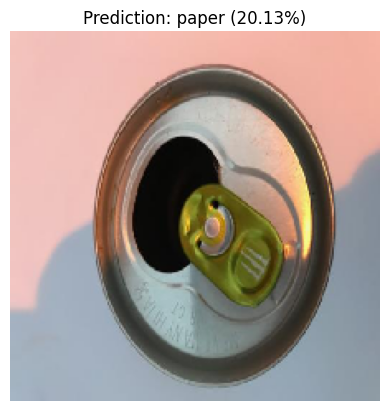

In [35]:
# Show prediction
print("Raw Prediction Vector:", prediction)
print("Predicted Index:", predicted_index)
print("Predicted Class:", predicted_class)
print(f"Confidence: {confidence:.2f}%")

# Show image with prediction
plt.imshow(img)
plt.title(f"Prediction: {predicted_class} ({confidence:.2f}%)")
plt.axis('off')
plt.show()


In [36]:
test_folder = "/Users/devidesai28/Documents/garbage-project/test_images"

for fname in os.listdir(test_folder):
    path = os.path.join(test_folder, fname)
    img = image.load_img(path, target_size=(224, 224))
    arr = image.img_to_array(img) / 255.0
    arr = np.expand_dims(arr, axis=0)

    pred = model.predict(arr)
    label = categories[np.argmax(pred)]
    confidence = np.max(pred) * 100

    print(f"{fname} → {label} ({confidence:.2f}%)")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
plastic_147.jpg → plastic (18.03%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
trash_006.jpg → metal (17.04%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
paper_006.jpg → paper (23.29%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
cardboard_003.jpg → plastic (17.16%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
metal_026.jpg → paper (20.13%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
glass_005.jpg → plastic (19.36%)


In [39]:
import os

# Ensure the folder exists
os.makedirs("model", exist_ok=True)

# Save the model
model.save("model/garbage_classifier_model.keras")
